#MNIST digit recognition using SVC in **scikit-learn**

#> Kaggle digit-recognition contest
---

In [1]:
from __future__ import division
import os, time, math, csv
import cPickle as pickle

import matplotlib.pyplot as plt

import numpy as np

from print_imgs import print_imgs # my own function to print a grid of square images

from sklearn.preprocessing    import StandardScaler
from sklearn.utils            import shuffle
from sklearn.cross_validation import train_test_split

from sklearn.svm              import SVC

np.random.seed(seed=1009)

%matplotlib inline

In [2]:
#%qtconsole

##Where's the data?

In [3]:
file_path = '../kaggle/data/'

train_img_deskewed_filename = 'kaggle_trainX_deskewed.csv'
test_img_deskewed_filename  = 'kaggle_testX_deskewed.csv'

train_img_original_filename = 'kaggle_trainX.csv'
test_img_original_filename  = 'kaggle_testX.csv'
    
train_label_filename   = 'kaggle_trainY.csv'
test_label_filename    = None                  # not provided

##How much of the data will we use?

In [4]:
portion = 1.0  # set to 1.0 for all of it less than 1.0 for less

##Read the training images and labels

In [5]:
# read both trainX files
with open(file_path + train_img_original_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainXo = np.ascontiguousarray(data, dtype = np.float64)  

with open(file_path + train_img_deskewed_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainXd = np.ascontiguousarray(data, dtype = np.float64)

# vertically concatenate the two files
trainX = np.vstack((trainXo, trainXd))

trainXo = None
trainXd = None

# scale trainX
scaler = StandardScaler()
scaler.fit(trainX)                 # find mean/std for trainX
trainX = scaler.transform(trainX)  # scale trainX with trainX mean/std

# read trainY twice and vertically concatenate
with open(file_path + train_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainYo = np.ascontiguousarray(data, dtype = np.int8) 
trainYd = np.ascontiguousarray(data, dtype = np.int8)

trainY = np.vstack((trainYo, trainYd)).ravel()

trainYo = None
trainYd = None
data    = None

# shuffle trainX & trainY
trainX, trainY = shuffle(trainX, trainY, random_state=0)

# use less data if specified
if portion < 1.0:
    trainX = trainX[:portion*trainX.shape[0]]
    trainY = trainY[:portion*trainY.shape[0]]

    
print("trainX shape: {0}".format(trainX.shape))
print("trainY shape: {0}\n".format(trainY.shape))

print(trainX.flags)

trainX shape: (84000, 784)
trainY shape: (84000,)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


##Print a sample of the training data

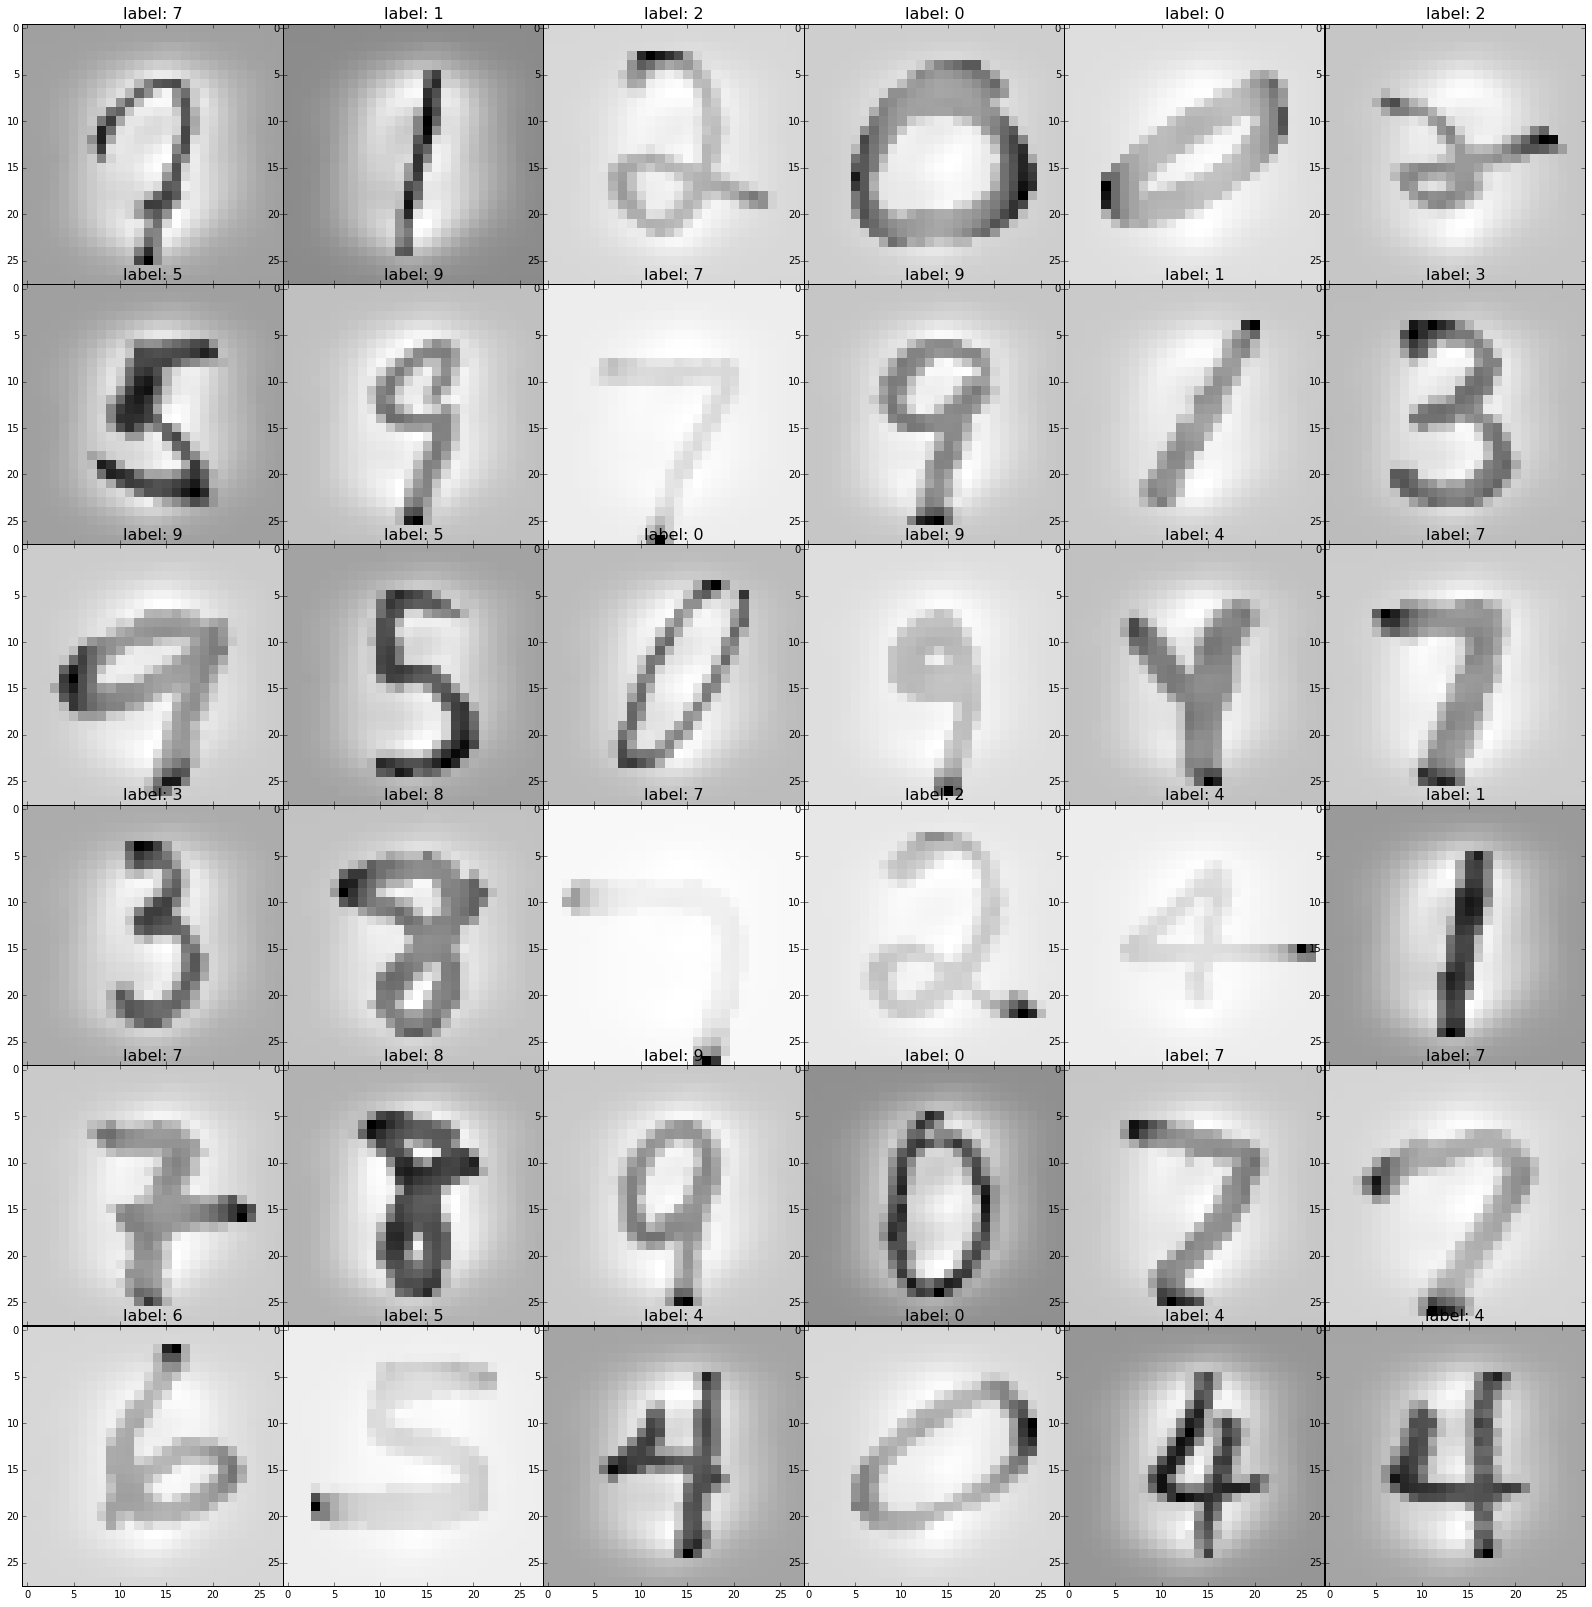

In [6]:
print_imgs(images           = trainX, 
           actual_labels    = trainY, 
           predicted_labels = trainY,
           starting_index   = np.random.randint(0, high=trainY.shape[0]-36, size=1)[0],
           size             = 6)

##Read the DESKEWED test images

In [7]:
with open(file_path + test_img_deskewed_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testX = np.ascontiguousarray(data, dtype = np.float64)  

# do not shuffle testX ... order is important for submission file
# ===============================================================
#testX = shuffle(testX, random_state=0)

# scale testX
testX = scaler.transform(testX)    # scale testX with trainX mean/std

# use less data if specified
if portion < 1.0:
    testX = testX[:portion*testX.shape[0]]
    
data = None

print("testX shape: {0}".format(testX.shape))

testX shape: (28000, 784)


#Use the smaller, fewer images for testing

***
#Fit the training set with optimal parameters

##Parameter Settings

In [8]:
# default parameters for SVC
# ==========================
default_svc_params = {}

default_svc_params['C']            = 1.0      # penalty
default_svc_params['class_weight'] = None     # Set the parameter C of class i to class_weight[i]*C
                                              # set to 'auto' for unbalanced classes
default_svc_params['gamma']        = 0.0      # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'

default_svc_params['kernel']       = 'rbf'    # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable
                                              # use of 'sigmoid' is discouraged
default_svc_params['shrinking']    = True     # Whether to use the shrinking heuristic.     
default_svc_params['probability']  = False    # Whether to enable probability estimates.    
default_svc_params['tol']          = 0.001    # Tolerance for stopping criterion. 
default_svc_params['cache_size']   = 200      # size of the kernel cache (in MB).

default_svc_params['max_iter']     = -1       # limit on iterations within solver, or -1 for no limit. 

default_svc_params['random_state'] = 1009    
default_svc_params['verbose']      = False 
default_svc_params['degree']       = 3        # 'poly' only
default_svc_params['coef0']        = 0.0      # 'poly' and 'sigmoid' only


# set the parameters for the classifier
# =====================================
svc_params = dict(default_svc_params)

svc_params['C']          = 25.595479226995359
svc_params['gamma']      = 0.00068664884500429981
svc_params['cache_size'] = 2000

#svc_params['verbose'] = True


# create the classifier itself
# ============================
svc_clf = SVC(**svc_params)

##Fit the classifier to the training set and save it to disk

In [9]:
t0 = time.time()

svc_clf.fit(trainX, trainY)

# Save the fitted clasifier to disk
pickle.dump( svc_clf, open( "../kaggle/SVC_RBF.pkl", "wb" ) )

print("time in minutes {0:.2f}".format((time.time()-t0)/60))

[LibSVM]time in minutes 8.56


#Predict the test set

In [10]:
t0 = time.time()

predicted_values = svc_clf.predict(testX)

print("time in minutes {0:.2f}".format((time.time()-t0)/60))

time in minutes 4.47


##Display the first 36 predictions

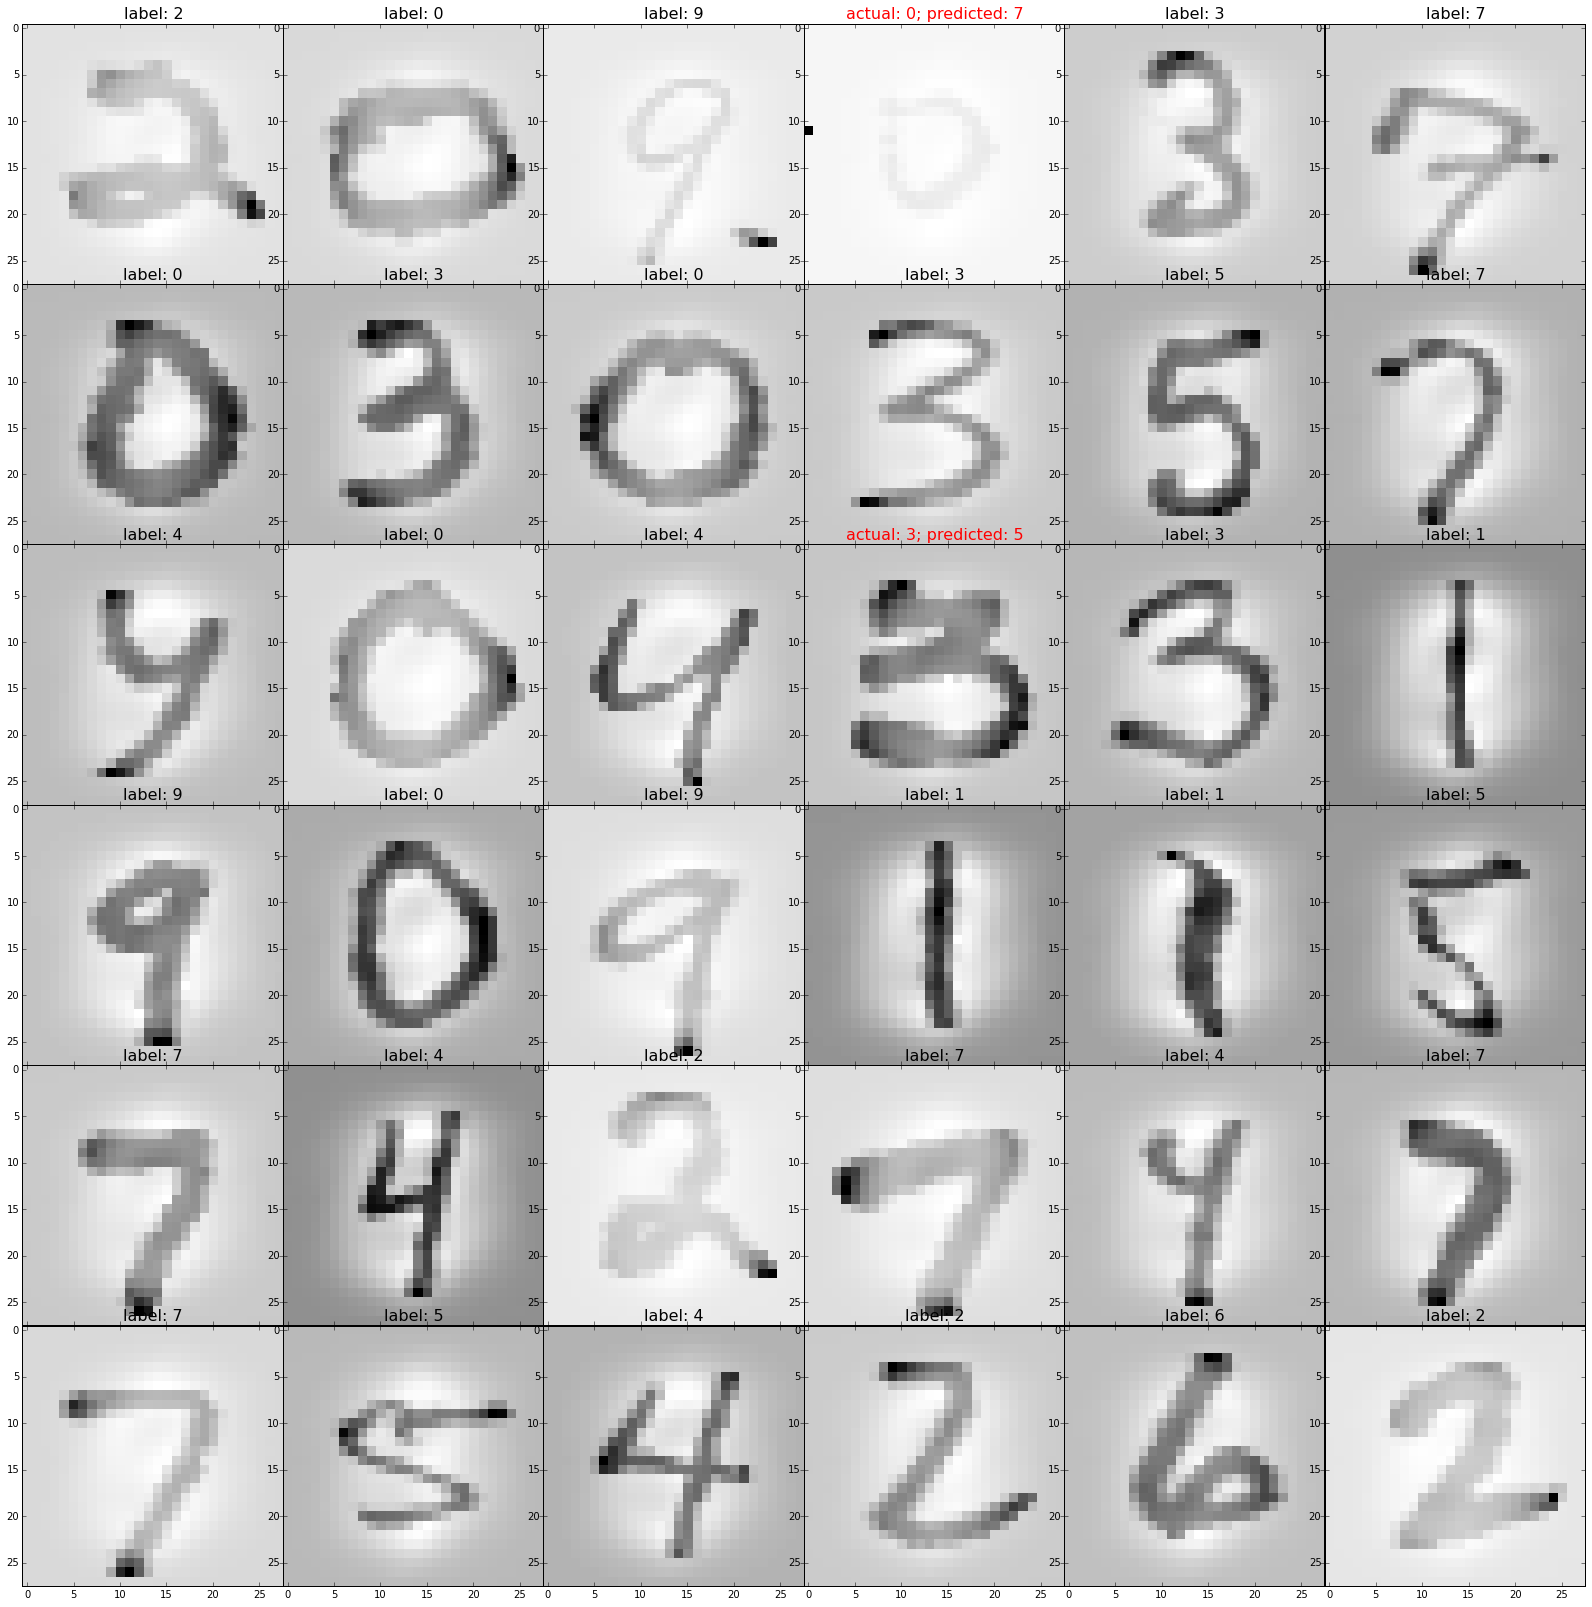

In [11]:
testY_first36 = [2,0,9,0,3,7,0,3,0,3,5,7,4,0,4,3,3,1,9,0,9,1,1,5,7,4,2,7,4,7,7,5,4,2,6,2]

print_imgs(images           = testX, 
           actual_labels    = testY_first36, 
           predicted_labels = predicted_values, 
           starting_index   = 0,
           size             = 6)

#Save the Kaggle submission file

In [12]:
with open('../kaggle/submissions/submission_SVC_RBF_deskewed.csv', 'w') as f_result:
    f_result.write('"ImageId","Label"\n')
    for i, y in enumerate(predicted_values, 1):
        f_result.write('{},"{}"\n'.format(i,y))